<a href="https://colab.research.google.com/github/Shrutiii24/ds_shruti/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard Folders
import os, pathlib

BASE_DIR = pathlib.Path("/content")
CSV_DIR = BASE_DIR / "csv_files"
OUT_DIR = BASE_DIR / "outputs"
CSV_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR.mkdir(exist_ok=True, parents=True)

print("Created:", CSV_DIR, OUT_DIR)

# Uploading Datasets
from google.colab import files

print("selecting fear_greed_index.csv and historical_data.csv files..")
uploaded = files.upload()

Created: /content/csv_files /content/outputs
selecting fear_greed_index.csv and historical_data.csv files..


Saving historical_data.csv to historical_data.csv
Saving fear_greed_index.csv to fear_greed_index.csv


In [ ]:
import pandas as pd
import numpy as np

FNG_PATH ="/content/fear_greed_index.csv"
TRADES_PATH ="/content/historical_data.csv"

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("/", "_")
        .str.replace("__", "_")
    )
    return df

# Read datasets
fng = pd.read_csv(FNG_PATH)
trades = pd.read_csv(TRADES_PATH)

fng = normalize_cols(fng)
trades = normalize_cols(trades)

print("Sentiment columns:", fng.columns.tolist())
print("Trades columns:", trades.columns.tolist())

# Peek heads
display(fng.head(5))
display(trades.head(5))

Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Trades columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
import pandas as pd
import numpy as np

fng = pd.read_csv("/content/fear_greed_index.csv", encoding="utf-8-sig")

# Normalize headers
fng.columns = (
    fng.columns.astype(str)
      .str.replace(r"\ufeff", "", regex=True)
      .str.strip().str.lower()
      .str.replace(r"\s+", "_", regex=True)
)

# 1) Parse time
fng["timestamp"] = pd.to_datetime(fng["timestamp"], unit="s", utc=True)

# 2) Make tz daily key
fng["fng_date_ts"] = fng["timestamp"].dt.tz_localize(None).dt.floor("D")

fng = fng[["fng_date_ts", "value", "classification"]].copy()

fng["classification"] = (
    fng["classification"].astype(str).str.strip().str.title()
)
valid_classes = ["Fear", "Greed", "Extreme Fear", "Extreme Greed"]
fng.loc[~fng["classification"].isin(valid_classes), "classification"] = np.nan
# 3) Collapse to one row per day
fng = (fng
       .sort_values(["fng_date_ts"])
       .groupby("fng_date_ts", as_index=False)
       .agg(value=("value","last"),
            classification=("classification","last"))
      )

print("Rows in FNG (daily):", len(fng))
print("Date range:", fng["fng_date_ts"].min(), "→", fng["fng_date_ts"].max())
print("Class distribution (incl. NaN):")
print(fng["classification"].value_counts(dropna=False).head(10))

Rows in FNG (daily): 2644
Date range: 2018-02-01 00:00:00 → 2025-05-02 00:00:00
Class distribution (incl. NaN):
classification
Fear             781
Greed            633
Extreme Fear     508
None             396
Extreme Greed    326
Name: count, dtype: int64


In [ ]:
df = df.drop(columns=["fng_date_ts"], errors="ignore")

df = df.merge(
    fng[["fng_date_ts","classification","value"]],
    left_on="trade_date_ts",
    right_on="fng_date_ts",
    how="left"
).drop(columns=["fng_date_ts"])

df.rename(columns={"value":"sentiment_value"}, inplace=True)

print("✅ Merged successfully!")
print(df["classification_y"].value_counts(dropna=False).head(10))
print("Date range:", df["trade_date_ts"].min(), "→", df["trade_date_ts"].max())

✅ Merged successfully!
classification_y
Fear             133871
Greed             36289
NaN               26961
None               7141
Extreme Greed      6962
Name: count, dtype: int64
Date range: 2023-03-28 00:00:00 → 2025-06-15 00:00:00


In [ ]:
import numpy as np

pnl_col = "closed_pnl" if "closed_pnl" in df.columns else ("closedpnl" if "closedpnl" in df.columns else None)

# 1) Win flag
if pnl_col:
    df["is_win"] = (df[pnl_col] > 0).astype("Int64")
else:
    df["is_win"] = pd.NA

# 2) Dollar volume
if "size_usd" in df.columns:
    df["dollar_volume"] = df["size_usd"].abs()
elif {"size_tokens","execution_price"}.issubset(df.columns):
    df["dollar_volume"] = (df["size_tokens"].abs() * df["execution_price"].abs())
else:
    df["dollar_volume"] = np.nan

# 3) Risk intensity
if "leverage" in df.columns:
    df["risk_intensity"] = df["size_tokens"].abs() * df["leverage"].abs()
else:
    df["risk_intensity"] = df["dollar_volume"]

print("Feature engineering complete.")


Feature engineering complete.


In [ ]:
daily = (
    df.groupby(["trade_date_ts", "classification"])
      .agg(
          trades=("trade_id","count"),
          accounts=("account","nunique"),
          total_pnl=(pnl_col,"sum"),
          avg_pnl=(pnl_col,"mean"),
          win_rate=("is_win","mean"),
          dollar_volume=("dollar_volume","sum"),
          risk_intensity=("risk_intensity","mean")
      )
      .reset_index()
)

daily.to_csv("/content/csv_files/daily_aggregates.csv", index=False)
print("✅ Saved daily aggregates → /content/csv_files/daily_aggregates.csv")
display(daily.head(20))


✅ Saved daily aggregates → /content/csv_files/daily_aggregates.csv


,trade_date_ts,classification,trades,accounts,total_pnl,avg_pnl,win_rate,dollar_volume,risk_intensity
0,2023-03-28,Greed,3,1,0.000000e+00,0.000000,0.0,4.770000e+02,159.000000
1,2023-11-14,Greed,1045,2,1.555034e+02,0.148807,0.274641,1.155543e+07,11057.827522
2,2024-03-09,Extreme Greed,6962,5,1.769655e+05,25.418772,0.490089,3.940677e+07,5660.265764
3,2024-10-27,Greed,35241,29,3.189461e+06,90.504272,0.451605,1.039478e+08,2949.625864
4,2025-02-19,Fear,133871,32,6.699925e+06,50.047622,0.415146,7.041585e+08,5259.977837


In [ ]:
acc_cols = [c for c in ["account","classification"] if c in df.columns]
if acc_cols:
    acc = (df
      .groupby(acc_cols, dropna=False)
      .agg(
          trades=("is_win","count"),
          win_rate=("is_win","mean"),
          total_pnl=("closedpnl","sum") if "closedpnl" in df.columns else ("is_win","sum"),
          avg_leverage=("leverage","mean") if "leverage" in df.columns else ("is_win","mean"),
          dollar_volume=("dollar_volume","sum"),
          mean_risk_intensity=("risk_intensity","mean"),
      ).reset_index()
    )
    acc.to_csv("/content/csv_files/account_by_sentiment.csv", index=False)
    display(acc.head(15))
    print("Saved → /content/csv_files/account_by_sentiment.csv")
else:
    print("No 'account' column found—skipping account-level aggregates.")


,account,classification,trades,win_rate,total_pnl,avg_leverage,dollar_volume,mean_risk_intensity
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,3356,0.405542,1361,0.405542,54854631.95,16345.241940
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,462,0.025974,12,0.025974,6842632.02,14810.891818
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Fear,3533,0.435041,1537,0.435041,5982611.50,1693.351684
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Greed,320,0.53125,170,0.53125,797679.97,2492.749906
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,NaN,3427,0.442369,1516,0.442369,5255196.19,1533.468395
5,0x271b280974205ca63b716753467d5a371de622ab,Fear,1136,0.430458,489,0.430458,12310719.50,10836.900968
6,0x271b280974205ca63b716753467d5a371de622ab,Greed,5,0.8,4,0.8,159708.30,31941.660000
7,0x271b280974205ca63b716753467d5a371de622ab,NaN,2668,0.246252,657,0.246252,21403012.62,8022.118673
8,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Fear,6794,0.432735,2940,0.432735,3622817.70,533.237813
9,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Greed,6472,0.443758,2872,0.443758,3129795.22,483.590114


Saved → /content/csv_files/account_by_sentiment.csv


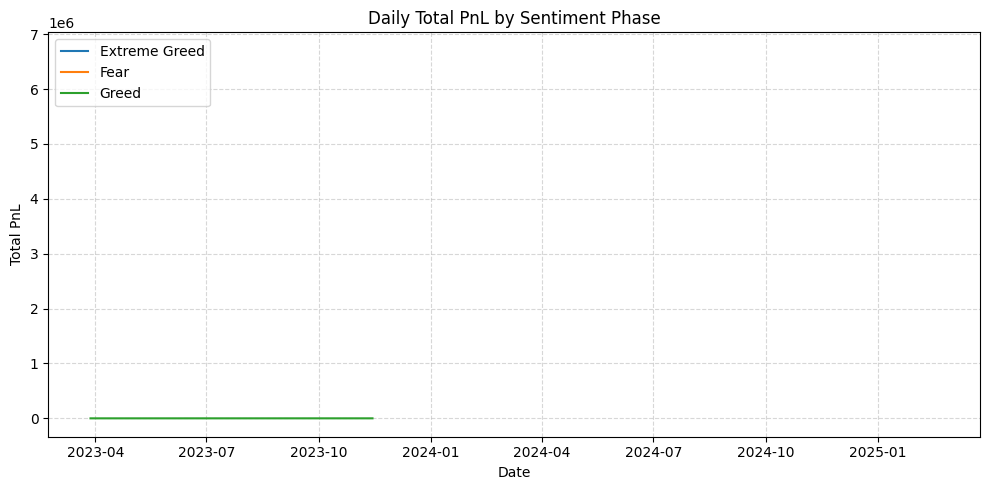

In [ ]:
import matplotlib.pyplot as plt

pivot = daily.pivot(index="trade_date_ts", columns="classification", values="total_pnl")

plt.figure(figsize=(10,5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)
plt.title("Daily Total PnL by Sentiment Phase")
plt.xlabel("Date")
plt.ylabel("Total PnL")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("/content/outputs/daily_total_pnl_4class.png", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("/content/outputs", exist_ok=True)

pnl_col = None
for c in ["closed_pnl", "closedpnl", "pnl", "realized_pnl", "realized_pnl_usd"]:
    if c in df.columns:
        pnl_col = c
        break
print("Using PnL column for plots:", pnl_col)
df_lab = df[df["classification"].isin(["Fear","Greed"])].copy()

# 1) Daily total PnL by sentiment over time
if {"trade_date_ts","classification"}.issubset(df_lab.columns) and pnl_col:
    temp = df_lab.groupby(["trade_date_ts","classification"])[pnl_col].sum().reset_index()
    pivot = temp.pivot(index="trade_date_ts", columns="classification", values=pnl_col)

    plt.figure()
    if "Fear" in pivot.columns:
        plt.plot(pivot.index, pivot["Fear"], label="Fear total PnL")
    if "Greed" in pivot.columns:
        plt.plot(pivot.index, pivot["Greed"], label="Greed total PnL")
    plt.xlabel("Date"); plt.ylabel("Total PnL"); plt.title("Daily Total PnL by Sentiment"); plt.legend()
    plt.savefig("/content/outputs/daily_total_pnl_by_sentiment.png", dpi=200, bbox_inches="tight"); plt.close()

# 1b) Cumulative PnL over time (all trades)
if {"trade_date_ts"}.issubset(df.columns) and pnl_col:
    cum = df.groupby("trade_date_ts")[pnl_col].sum().sort_index().cumsum()
    plt.figure(); plt.plot(cum.index, cum.values)
    plt.xlabel("Date"); plt.ylabel("Cumulative PnL"); plt.title("Cumulative PnL (All Trades)")
    plt.savefig("/content/outputs/cumulative_pnl.png", dpi=200, bbox_inches="tight"); plt.close()

# 2) Win rate by sentiment
if {"classification","is_win"}.issubset(df_lab.columns) and df_lab["is_win"].notna().any():
    wr = df_lab.groupby("classification")["is_win"].mean().reindex(["Fear","Greed"])
    plt.figure(); plt.bar(wr.index.astype(str), wr.values.astype(float))
    plt.ylabel("Win Rate"); plt.title("Win Rate by Sentiment (per trade)")
    plt.savefig("/content/outputs/winrate_by_sentiment.png", dpi=200, bbox_inches="tight"); plt.close()

# 3) Trading intensity by sentiment (Dollar Volume)
if {"classification","dollar_volume"}.issubset(df_lab.columns):
    dv = df_lab.groupby("classification")["dollar_volume"].mean().reindex(["Fear","Greed"])
    plt.figure(); plt.bar(dv.index.astype(str), dv.values.astype(float))
    plt.ylabel("Mean Dollar Volume"); plt.title("Trading Intensity by Sentiment")
    plt.savefig("/content/outputs/dollar_volume_by_sentiment.png", dpi=200, bbox_inches="tight"); plt.close()

# 4) Risk proxy by sentiment
if {"classification","risk_intensity"}.issubset(df_lab.columns):
    ri = df_lab.groupby("classification")["risk_intensity"].mean().reindex(["Fear","Greed"])
    plt.figure(); plt.bar(ri.index.astype(str), ri.values.astype(float))
    plt.ylabel("Mean Risk Proxy"); plt.title("Risk Exposure by Sentiment")
    plt.savefig("/content/outputs/risk_intensity_by_sentiment.png", dpi=200, bbox_inches="tight"); plt.close()

# 5) Trades per day by sentiment
if {"trade_date_ts","classification"}.issubset(df_lab.columns):
    cnt = (df_lab.groupby(["trade_date_ts","classification"])["trade_id"]
           .count().reset_index(name="trades"))
    pv = cnt.pivot(index="trade_date_ts", columns="classification", values="trades")
    plt.figure()
    if "Fear" in pv:  plt.plot(pv.index, pv["Fear"],  label="Fear trades/day")
    if "Greed" in pv: plt.plot(pv.index, pv["Greed"], label="Greed trades/day")
    plt.xlabel("Date"); plt.ylabel("Trades"); plt.title("Trades per Day by Sentiment"); plt.legend()
    plt.savefig("/content/outputs/trades_per_day_by_sentiment.png", dpi=200, bbox_inches="tight"); plt.close()

# 6) Daily PnL vs Dollar Volume scatter (behavior vs outcome)
if {"trade_date_ts","dollar_volume"}.issubset(df.columns) and pnl_col:
    day = (df.groupby(["trade_date_ts","classification"])
             .agg(total_pnl=(pnl_col,"sum"), dollar_volume=("dollar_volume","sum"))
             .reset_index())
    plt.figure()
    for lab in ["Fear","Greed"]:
        sub = day[day["classification"]==lab]
        if len(sub):
            plt.scatter(sub["dollar_volume"], sub["total_pnl"], s=12, alpha=0.6, label=lab)
    plt.xlabel("Daily Dollar Volume"); plt.ylabel("Daily Total PnL")
    plt.title("Daily PnL vs Trading Volume by Sentiment"); plt.legend()
    plt.savefig("/content/outputs/scatter_daily_pnl_vs_volume.png", dpi=200, bbox_inches="tight"); plt.close()

print("Saved charts in /content/outputs/")


Using PnL column for plots: closed_pnl
Saved charts in /content/outputs/


In [ ]:
def data_dictionary(df: pd.DataFrame, name: str) -> pd.DataFrame:
    return pd.DataFrame({
        "dataset": name,
        "column": df.columns,
        "dtype": df.dtypes.astype(str),
        "non_null_count": df.notna().sum().values,
        "null_share": df.isna().mean().values
    })

dd = pd.concat([
    data_dictionary(fng, "fear_greed"),
    data_dictionary(trades, "trades_raw"),
    data_dictionary(df, "joined")
], ignore_index=True)

dd.to_csv("/content/csv_files/data_dictionary.csv", index=False)
display(dd.head(40))
print("Saved → /content/csv_files/data_dictionary.csv")


,dataset,column,dtype,non_null_count,null_share
0,fear_greed,fng_date_ts,datetime64[ns],2644,0.000000
1,fear_greed,value,int64,2644,0.000000
2,fear_greed,classification,object,2248,0.149773
3,trades_raw,account,object,211224,0.000000
4,trades_raw,coin,object,211224,0.000000
5,trades_raw,execution_price,float64,211224,0.000000
6,trades_raw,size_tokens,float64,211224,0.000000
7,trades_raw,size_usd,float64,211224,0.000000
8,trades_raw,side,object,211224,0.000000
9,trades_raw,timestamp_ist,object,211224,0.000000


Saved → /content/csv_files/data_dictionary.csv


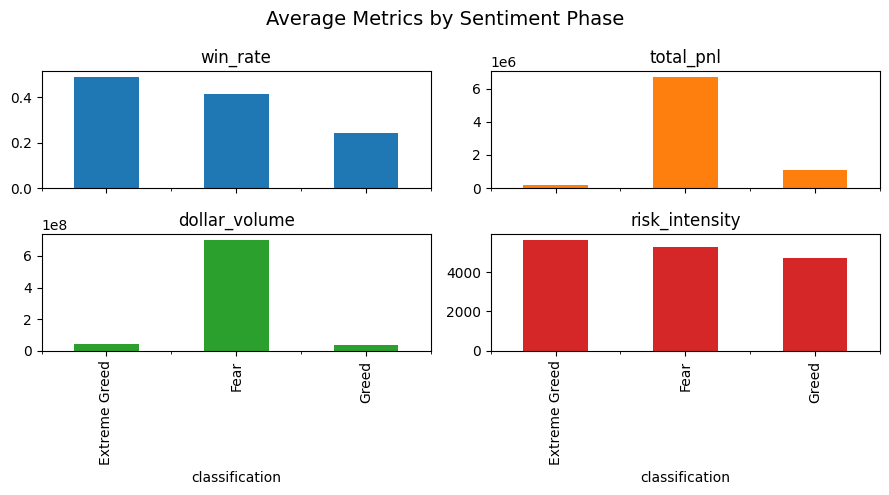

In [ ]:
sent_summary = (
    daily.groupby("classification")[["win_rate","total_pnl","dollar_volume","risk_intensity"]]
         .mean().sort_index()
)

sent_summary.plot(kind="bar", figsize=(9,5), subplots=True, layout=(2,2), legend=False)
plt.suptitle("Average Metrics by Sentiment Phase", fontsize=14)
plt.tight_layout()
plt.savefig("/content/outputs/bar_avg_metrics_by_sentiment.png", dpi=200, bbox_inches="tight")
plt.show()